# 10. Backtesting orientado a eventos

Para este tipo de casos, usaremos la librería `backtrader`, la que implica crear algunas funciones y clases antes de implementarla. En general, el código se construye de la siguiente forma:

```python
class xStrategy(bt.Strategy):
    params = ()
    
    def __init__(self):
        #Codigo
    
    def log(self, txt):
        #Codigo
        
    def notify_order(self, order):
        #Codigo
    
    def notify_trade(self, trade):
        #Codigo
        
    def next(self):
        #Codigo
        
    def start(self):
        #Codigo
        
    def stop(self):
        #Codigo

```


En cada bloque de funciones dentro de la clase se debe especificar:

* `__init__(self):` Se definen los objetos que se quiere seguir.
* `log(self, txt):` Se crea un registro (log) de lo que va ocurriendo en el backtesting.
* `notify_order(self, order):` Reporta el *status* de la orden. En general, en el día $t$ el indicador sugiere si se abre o cierra una posición basado en el precio de cierre (o el último precio dependiendo de la frecuencia de las transacciones). Entonces, la orden será ejecutada al siguiente día (o siguiente precio).
* `notify_trade(self, trade):` Reporta los resultados de las transacciones después que la posición se cerró.
* `next(self):` Este método contiene la lógica de la estrategia de inversión.
* `start/stop(self):` Permiten reportar el valor del portfolio.

Por ejemplo, hagamos el backtest de Apple usando SMA(20):

In [1]:
!pip install backtrader quantstats --quiet

from datetime import datetime
import backtrader as bt
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import quantstats as qs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.4 MB/s eta 0:00:00


In [2]:
aapl = yf.download("AAPL", start = "2024-01-01", end = "2024-12-31", auto_adjust=True, multi_level_index=False)

data = bt.feeds.PandasData(dataname=aapl)
data

[*********************100%***********************]  1 of 1 completed


## Estrategia de prueba

In [3]:
# Crear una estrategia de prueba
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Función de registro para esta estrategia'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Seguir el precio de cierre en la serie de datos data[0]
        self.dataclose = self.datas[0].close

        # Para seguir órdenes pendientes
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Orden de compra/venta enviada/aceptada por el broker - Nada que hacer
            return

        # Comprobar si una orden ha sido completada
        # Atención: el broker podría rechazar la orden si no hay suficiente efectivo
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('COMPRA EJECUTADA, %.2f' % order.executed.price)
            elif order.issell():
                self.log('VENTA EJECUTADA, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Orden Cancelada/Margen/Rechazada')

        # Registrar: no hay orden pendiente
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f"Resultados de la operación - bruto: {trade.pnl:.2f}, Neto: {trade.pnlcomm:.2f}")

    def next(self):
        # Simplemente registrar el precio de cierre de la serie de referencia
        self.log('Cierre, %.2f' % self.dataclose[0])

        # Comprobar si hay una orden pendiente ... si sí, no podemos enviar una segunda
        if self.order:
            return

        # Comprobar si estamos en el mercado
        if not self.position:

            # podriamos comprar si
            if self.dataclose[0] < self.dataclose[-1]:
                    # el cierre actual es menor que el cierre anterior

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # el cierre anterior es menor que el cierre pre-anterior

                        # compra
                        self.log('COMPRA CREADA, %.2f' % self.dataclose[0])

                        # Mantener un registro de la orden creada para evitar una segunda orden
                        self.order = self.buy()

        else:

            # Ya en el mercado ... podríamos vender
            if len(self) >= (self.bar_executed + 5):
                # venta
                self.log('VENTA CREADA, %.2f' % self.dataclose[0])

                # Mantener un registro de la orden creada para evitar una segunda orden
                self.order = self.sell()

    def start(self):
        print(f"Valor inicial portfolio: {self.broker.get_value():.2f}")

    def stop(self):
        print(f"Valor final portfolio: {self.broker.get_value():.2f}")

Inicializamos el backtest

In [4]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.adddata(data)
cerebro.broker.setcash(1000)
cerebro.addstrategy(TestStrategy)
cerebro.addobserver(bt.observers.Value)
#cerebro.addsizer(bt.sizers.SizerFix, stake=10)

cerebro.run()

Valor inicial portfolio: 1000.00
2024-01-02, Cierre, 183.90
2024-01-02, COMPRA CREADA, 183.90
2024-01-03, COMPRA EJECUTADA, 182.50
2024-01-03, Cierre, 182.53
2024-01-04, Cierre, 180.21
2024-01-05, Cierre, 179.48
2024-01-08, Cierre, 183.82
2024-01-09, Cierre, 183.41
2024-01-10, Cierre, 184.45
2024-01-10, VENTA CREADA, 184.45
2024-01-11, VENTA EJECUTADA, 184.79
2024-01-11, Resultados de la operación - bruto: 2.30, Neto: 2.30
2024-01-11, Cierre, 183.85
2024-01-12, Cierre, 184.18
2024-01-16, Cierre, 181.91
2024-01-17, Cierre, 180.97
2024-01-17, COMPRA CREADA, 180.97
2024-01-18, COMPRA EJECUTADA, 184.35
2024-01-18, Cierre, 186.87
2024-01-19, Cierre, 189.77
2024-01-22, Cierre, 192.08
2024-01-23, Cierre, 193.35
2024-01-24, Cierre, 192.68
2024-01-25, Cierre, 192.35
2024-01-25, VENTA CREADA, 192.35
2024-01-26, VENTA EJECUTADA, 192.45
2024-01-26, Resultados de la operación - bruto: 8.10, Neto: 8.10
2024-01-26, Cierre, 190.62
2024-01-26, COMPRA CREADA, 190.62
2024-01-29, COMPRA EJECUTADA, 190.21


<IPython.core.display.Javascript object>

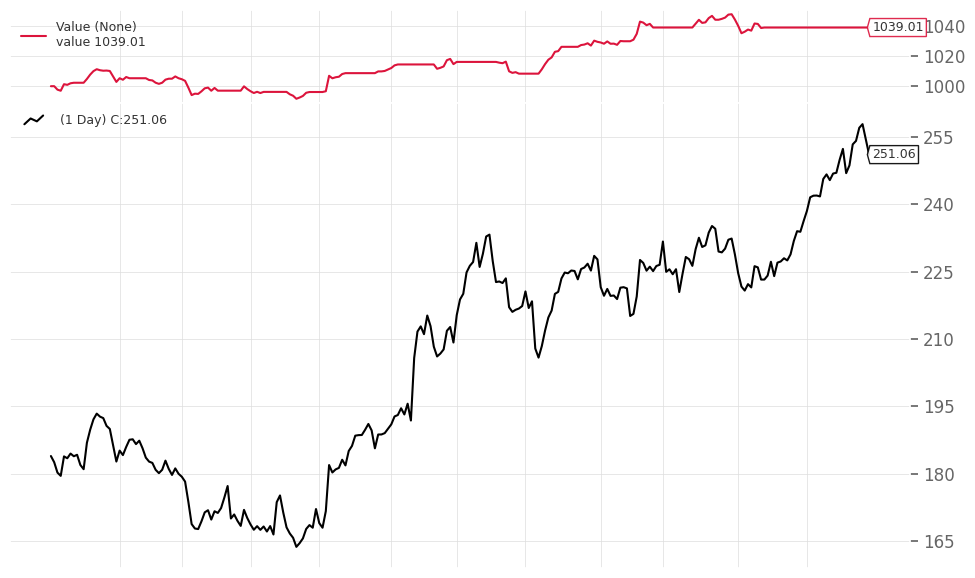

In [5]:
cerebro.plot(iplot = True, volume = False)[0][0]

## Estrategia SMA

Algunas funciones adicionales para hacer el trabajo más fácil:

In [6]:
class MyBuySell(bt.observers.BuySell):
    """
    Custom color definitions of the buy/sell indicators.
    """
    plotlines = dict(
        buy=dict(marker="^", markersize=8.0, color="green", fillstyle="full"),
        sell=dict(marker="v", markersize=8.0, color="red", fillstyle="full")
    )

def get_action_log_string(dir, action, price, size, asset=None, cost=None,
                          commission=None, cash=None, open=None, close=None):
    """
    Helper function for logging. Creates a string indicating a
    created/executed buy/sell order.

    Args:
        dir (str): The direction of the position, can be a value in ["b", "s"]
        action (str): The action, can be a value in ["e", "c"]
        price (float): The price
        size (float, optional): The size. Defaults to None.
        asset (str): name of the asset
        cost (float, optional): The cost. Defaults to None.
        commission (float, optional): The comission. Defaults to None.
        cash (float, optional): The cash amount. Defaults to None.
        open (float, optional): The open price. Defaults to None.
        close (float, optional): The close price. Defaults to None.

    Returns:
        str: The string used for logging
    """
    dir_dict = {
        "b": "Compra",
        "s": "Vende",
    }

    action_dict = {
        "e": "EXECUTED",
        "c": "CREATED"
    }

    str = (
        f"{dir_dict[dir]} {action_dict[action]} - "
        f"Price: {price:.2f}, Size: {size:.2f}"
    )

    if asset is not None:
        str = str + f", Asset: {asset}"


    if action == "e":
        if cost is not None:
            str = str + f", Costo: {cost:.2f}"
        if commission is not None:
            str = str + f", Commisión: {commission:.2f}"
    elif action == "c":
        if cash is not None:
            str = str + f", Efectivo: {cash:.2f}"
        if open is not None:
            str = str + f", Open: {open:.2f}"
        if close is not None:
            str = str + f", Close: {close:.2f}"


    return str

def get_result_log_string(gross, net):
    """
    Helper function for logging. Creates a string indicating the summary of
    an operation.

    Args:
        gross (float): the gross outcome
        net (float): the net outcome

    Returns:
        str: The string used for logging
    """
    str = f"Resultados de la operación - bruto: {gross:.2f}, Neto: {net:.2f}"
    return str

In [7]:
class SmaStrategy(bt.Strategy):
    params = (("ma_period", 20), ) #Media Móvil Simple (SMA) de 20 períodos

    def __init__(self):
        # Sigue al precio de cierre en la serie de datos
        self.data_close = self.datas[0].close

        # Sigue las órdenes pendientes
        self.order = None

        # Agrega el indicador de media móvil simple (SMA)
        self.sma = bt.ind.SMA(self.datas[0],
                              period=self.params.ma_period)

    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f"{dt}: {txt}")

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Si la orden es enviada o aceptada, no hacer nada
            return

        # Reporta la ejecución de la orden
        if order.status in [order.Completed]:

            direction = "b" if order.isbuy() else "s"
            log_str = get_action_log_string(
                    dir=direction,
                    action="e",
                    price=order.executed.price,
                    size=order.executed.size,
                    cost=order.executed.value,
                    commission=order.executed.comm
                )
            self.log(log_str)

        # Reporta si la orden falló
        elif order.status in [order.Canceled, order.Margin,
                              order.Rejected]:
            self.log("Orden Fallida")

        # Reinicia la orden
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(get_result_log_string(gross=trade.pnl, net=trade.pnlcomm))

    def next(self):
        # No hacer nada si hay una orden pendiente
        if self.order:
            return

        # Obtiene el efectivo actual y el precio
        cash = self.broker.getcash()
        price = self.data_close[0]

        # Calcula el número máximo de acciones a comprar con el efectivo disponible
        # Asegura que el precio no sea cero para evitar la división por cero
        if price > 0:
            size_to_buy = math.floor(cash / price)
        else:
            size_to_buy = 0

        # Revisa si hay una posición abierta
        if not self.position:
            # Condición de compra
            if self.data_close[0] > self.sma[0]:
                if size_to_buy > 0: # Solo compra si se puede comprar al menos 1 acción
                    self.log(get_action_log_string("b", "c", self.data_close[0], size=size_to_buy))
                    self.order = self.buy(size=size_to_buy) # Pasa el tamaño calculado
                else:
                    self.log(f"No hay suficiente efectivo para comprar a {price:.2f}")
        else:
            # Condición de venta (vende toda la posición)
            if self.data_close[0] < self.sma[0]:
                size_to_sell = self.position.size # Vende toda la posición abierta
                self.log(get_action_log_string("s", "c", self.data_close[0], size=size_to_sell))
                self.order = self.sell(size=size_to_sell) # Pasa el tamaño de la posición

    def start(self):
        print(f"Valor inicial portfolio: {self.broker.get_value():.2f}")

    def stop(self):
        print(f"Valor final portfolio: {self.broker.get_value():.2f}")

Inicializamos el backtest

In [8]:
cerebro = bt.Cerebro(stdstats = False)

cerebro.adddata(data)
cerebro.broker.setcash(1000)
cerebro.addstrategy(SmaStrategy)
cerebro.addobserver(MyBuySell)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.Returns, _name="returns")
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name="time_return")

res = cerebro.run()

Valor inicial portfolio: 1000.00
2024-01-30: Compra CREATED - Price: 186.28, Size: 5.00
2024-01-31: Compra EXECUTED - Price: 185.29, Size: 5.00, Costo: 926.45, Commisión: 0.00
2024-01-31: Vende CREATED - Price: 182.67, Size: 5.00
2024-02-01: Vende EXECUTED - Price: 182.27, Size: -5.00, Costo: 926.45, Commisión: 0.00
2024-02-01: Resultados de la operación - bruto: -15.11, Neto: -15.11
2024-02-06: Compra CREATED - Price: 187.53, Size: 5.00
2024-02-07: Compra EXECUTED - Price: 188.86, Size: 5.00, Costo: 944.28, Commisión: 0.00
2024-02-08: Vende CREATED - Price: 186.56, Size: 5.00
2024-02-09: Vende EXECUTED - Price: 187.12, Size: -5.00, Costo: 944.28, Commisión: 0.00
2024-02-09: Resultados de la operación - bruto: -8.66, Neto: -8.66
2024-03-19: Compra CREATED - Price: 174.66, Size: 5.00
2024-03-20: Compra EXECUTED - Price: 174.30, Size: 5.00, Costo: 871.49, Commisión: 0.00
2024-03-21: Vende CREATED - Price: 169.98, Size: 5.00
2024-03-22: Vende EXECUTED - Price: 170.37, Size: -5.00, Costo: 

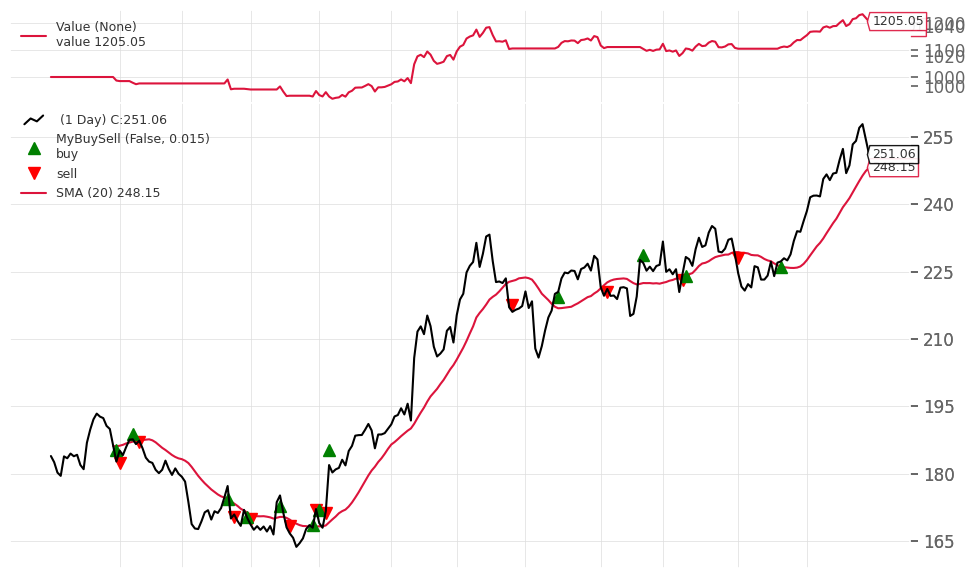

In [9]:
cerebro.plot(iplot = True, volume = False)[0][0]

Here are the daily returns of the strategy:

In [10]:
returns_dict = res[0].analyzers.time_return.get_analysis()
returns_df = (
    pd.DataFrame(list(returns_dict.items()),
                 columns = ["date", "return"])
    .set_index("date")
)
returns_df

,return
date,
2024-01-02,0.000000
2024-01-03,0.000000
2024-01-04,0.000000
2024-01-05,0.000000
2024-01-08,0.000000
...,...
2024-12-23,0.002558
2024-12-24,0.009585
2024-12-26,0.002657


And finally, the quantitative strategy report:

In [11]:
rf = .04
qs.reports.metrics(returns_df["return"], benchmark = "AAPL", rf = rf, mode = "full", prepare_returns = False)

                           Benchmark (AAPL)    Strategy
-------------------------  ------------------  ----------
Start Period               2024-01-02          2024-01-02
End Period                 2024-12-30          2024-12-30
Risk-Free Rate             4.0%                4.0%
Time in Market             92.0%               60.0%

Cumulative Return          34.78%              20.5%
CAGR﹪                     34.94%              20.59%

Sharpe                     1.31                1.02
Prob. Sharpe Ratio         80.71%              74.12%
Smart Sharpe               1.29                1.0
Sortino                    2.02                1.56
Smart Sortino              1.99                1.54
Sortino/√2                 1.43                1.1
Smart Sortino/√2           1.41                1.09
Omega                      1.26                1.26

Max Drawdown               -12.78%             -9.0%
Max DD Date                2024-04-19          2024-10-07
Max DD Period Start        20

## Agregando comisiones

In [12]:
cerebro.broker.setcommission(commission=0.005)
cerebro.run()

Valor inicial portfolio: 1000.00
2024-01-30: Compra CREATED - Price: 186.28, Size: 5.00
2024-01-31: Compra EXECUTED - Price: 185.29, Size: 5.00, Costo: 926.45, Commisión: 4.63
2024-01-31: Vende CREATED - Price: 182.67, Size: 5.00
2024-02-01: Vende EXECUTED - Price: 182.27, Size: -5.00, Costo: 926.45, Commisión: 4.56
2024-02-01: Resultados de la operación - bruto: -15.11, Neto: -24.30
2024-02-06: Compra CREATED - Price: 187.53, Size: 5.00
2024-02-07: Compra EXECUTED - Price: 188.86, Size: 5.00, Costo: 944.28, Commisión: 4.72
2024-02-08: Vende CREATED - Price: 186.56, Size: 5.00
2024-02-09: Vende EXECUTED - Price: 187.12, Size: -5.00, Costo: 944.28, Commisión: 4.68
2024-02-09: Resultados de la operación - bruto: -8.66, Neto: -18.06
2024-03-19: Compra CREATED - Price: 174.66, Size: 5.00
2024-03-20: Compra EXECUTED - Price: 174.30, Size: 5.00, Costo: 871.49, Commisión: 4.36
2024-03-21: Vende CREATED - Price: 169.98, Size: 5.00
2024-03-22: Vende EXECUTED - Price: 170.37, Size: -5.00, Costo:

## Optimizando estrategias

In [15]:
class SmaStrategy(bt.Strategy):
    params = (("ma_period", 20), ) #Media Móvil Simple (SMA) de 20 períodos

    def __init__(self):
        # Sigue al precio de cierre en la serie de datos
        self.data_close = self.datas[0].close

        # Sigue las órdenes pendientes
        self.order = None

        # Agrega el indicador de media móvil simple (SMA)
        self.sma = bt.ind.SMA(self.datas[0],
                              period=self.params.ma_period)

    def log(self, txt, do_print=False):
        if do_print:
            dt = self.datas[0].datetime.date(0).isoformat()
            print(f"{dt}: {txt}")

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Si la orden es enviada o aceptada, no hacer nada
            return

        # Reporta la ejecución de la orden
        if order.status in [order.Completed]:

            direction = "b" if order.isbuy() else "s"
            log_str = get_action_log_string(
                    dir=direction,
                    action="e",
                    price=order.executed.price,
                    size=order.executed.size,
                    cost=order.executed.value,
                    commission=order.executed.comm
                )
            self.log(log_str)

        # Reporta si la orden falló
        elif order.status in [order.Canceled, order.Margin,
                              order.Rejected]:
            self.log("Orden Fallida")

        # Reinicia la orden
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(get_result_log_string(gross=trade.pnl, net=trade.pnlcomm))

    def next(self):
        # No hacer nada si hay una orden pendiente
        if self.order:
            return

        # Obtiene el efectivo actual y el precio
        cash = self.broker.getcash()
        price = self.data_close[0]

        # Calcula el número máximo de acciones a comprar con el efectivo disponible
        # Asegura que el precio no sea cero para evitar la división por cero
        if price > 0:
            size_to_buy = math.floor(cash / price)
        else:
            size_to_buy = 0

        # Revisa si hay una posición abierta
        if not self.position:
            # Condición de compra
            if self.data_close[0] > self.sma[0]:
                if size_to_buy > 0: # Solo compra si se puede comprar al menos 1 acción
                    self.log(get_action_log_string("b", "c", self.data_close[0], size=size_to_buy))
                    self.order = self.buy(size=size_to_buy) # Pasa el tamaño calculado
                else:
                    self.log(f"No hay suficiente efectivo para comprar a {price:.2f}")
        else:
            # Condición de venta (vende toda la posición)
            if self.data_close[0] < self.sma[0]:
                size_to_sell = self.position.size # Vende toda la posición abierta
                self.log(get_action_log_string("s", "c", self.data_close[0], size=size_to_sell))
                self.order = self.sell(size=size_to_sell) # Pasa el tamaño de la posición

    def stop(self):
        print(f"Valor final portfolio con ma_perido {self.params.ma_period}: {self.broker.get_value():.2f}")

In [16]:
cerebro = bt.Cerebro()

cerebro.adddata(data)
cerebro.broker.setcash(1000)
strats = cerebro.optstrategy(
        SmaStrategy,
        ma_period=range(10, 31))

res = cerebro.run()


Valor final portfolio con ma_perido 11: 1277.61Valor final portfolio con ma_perido 10: 1223.44

Valor final portfolio con ma_perido 12: 1315.71
Valor final portfolio con ma_perido 13: 1305.53
Valor final portfolio con ma_perido 15: 1209.75
Valor final portfolio con ma_perido 14: 1149.28
Valor final portfolio con ma_perido 16: 1210.74
Valor final portfolio con ma_perido 17: 1271.53
Valor final portfolio con ma_perido 18: 1218.13
Valor final portfolio con ma_perido 19: 1202.63
Valor final portfolio con ma_perido 20: 1205.05
Valor final portfolio con ma_perido 21: 1203.19
Valor final portfolio con ma_perido 22: 1198.89
Valor final portfolio con ma_perido 23: 1198.89
Valor final portfolio con ma_perido 24: 1197.65
Valor final portfolio con ma_perido 25: 1194.49
Valor final portfolio con ma_perido 26: 1124.84
Valor final portfolio con ma_perido 27: 1099.31
Valor final portfolio con ma_perido 28: 1063.03
Valor final portfolio con ma_perido 29: 1099.62
Valor final portfolio con ma_perido 30: 

## Actividad

En base a la estrategia presente en la siguiente página web [helloalgotrading](https://www.backtrader.com/home/helloalgotrading/), realice una optimización de parámetros con la librería backtrader. Optimice su estrategia para el año 2023 y pruebe la estrategia ganadora para el año 2024.
